# Free-Fermion Volume Benchmark – Tutorial

This notebook shows how to:

1. Construct a **FreeFermionBenchmark** .
2. Generate a small set of benchmark circuits.
3. Simulate those circuits using **Qiskit Aer**.
4. Attach the measurement results back to the benchmark.
5. Run the benchmark evaluation and inspect the results.

## Setup

In [1]:
from ScalableVolumetricBenchmark import FreeFermionVolumeBenchmark

from qiskit import QuantumCircuit as QiskitCircuit
from qiskit_aer import AerSimulator

## 2. Create a Free-Fermion benchmark

We now construct a small free-fermion benchmark instance. For a quick demo, we use only a few qubits and samples so that simulation is fast.

In [2]:
# Number of qubits and samples for the demo
n_qubits = 5
sample_size = 25
shots = 2048

benchmark = FreeFermionVolumeBenchmark(
    number_of_qubits=n_qubits,
    sample_size=sample_size,
    format='qasm2',
    target_sdk='qiskit',
    shots=shots,
    auto_save=False,
    workdir='test'
)

# Generate the benchmark samples (random free-fermion circuits)
benchmark.create_benchmark()
benchmark

FreeFermionVolumeBenchmark(
  benchmark_id='free_fermion_nq5_s25_20260126T103857_927f35d7',
  number_of_qubits=5,
  sample_size=25,
  format='qasm2',
  target_sdk='qiskit',
  workdir=WindowsPath('test'),
)

Each sample contains a list of circuits with associated Pauli observables. The circuits are already compiled to QASM strings, which we can feed directly to Qiskit.

In [5]:
sample = benchmark.samples[0]
print('Sample keys:', sample.keys())
print('Number of circuits in sample 0:', len(sample['circuits']))

first_circuit = sample['circuits'][0]
print('Circuit ID:', first_circuit['circuit_id'])
print('Observable:', first_circuit['observable'])
print('\nQASM preview:\n')
print('\n'.join(first_circuit['qasm'].splitlines()[:15]))

Sample keys: dict_keys(['sample_id', 'sample_metadata', 'circuits'])
Number of circuits in sample 0: 10
Circuit ID: 0_maj_0
Observable: ZZYII

QASM preview:

OPENQASM 2.0;

include "qelib1.inc";

qreg q[5];
creg c[5];

h q[3];
rz(-0.648443) q[0];
rz(-1.823632) q[1];
h q[0];
h q[1];
cx q[0], q[1];
rz(0.453100) q[1];
cx q[0], q[1];


## 3. Simulate the circuits with Qiskit Aer

We now loop over all benchmark circuits, convert each QASM string into a
Qiskit `QuantumCircuit`, and simulate it with `AerSimulator`.

The benchmark base class `add_experimental_results` expects a mapping
from `circuit_id` to a counts dictionary (`bitstring -> count`).

In [6]:
# Create the Qiskit simulator
simulator = AerSimulator()

counts_data = {}  # circuit_id -> counts dict

for sample in benchmark.samples:
    for circuit in sample['circuits']:
        cid = circuit['circuit_id']
        qasm = circuit['qasm']

        # Build a Qiskit circuit from QASM
        qk_circ = QiskitCircuit.from_qasm_str(qasm)

        # Run the simulation
        job = simulator.run(qk_circ, shots=benchmark.shots)
        result = job.result()
        counts = result.get_counts()
        keys = list(counts.keys())
        new_counts={}
        
        for k in keys:
            new_counts[k[::-1]] = counts[k]

        counts = new_counts
        # Convert to a plain dict of str->int
        counts_data[cid] = {str(bitstring): int(count) for bitstring, count in counts.items()}

len(counts_data)

250

## 4. Attach results to the benchmark

We now attach the simulated counts to the benchmark using
`add_experimental_results`. This stores the results in a canonical
schema under `benchmark.experimental_results`.

In [7]:
benchmark.add_experimental_results(
    counts_data,
    experiment_id="qiskit_aer_demo",
    platform="qiskit-aer",
    experiment_metadata={"backend": "AerSimulator"},
)

list(benchmark.experimental_results.keys())

['experiment_id', 'platform', 'experiment_metadata', 'results']

## 5. Evaluate the free-fermion benchmark

The `FreeFermionBenchmark` implements `evaluate_benchmark`, which
computes the parallel and orthogonal projection values for each
sample based on the measured Majorana expectation values.

In [8]:
evaluation = benchmark.evaluate_benchmark()


 Free-Fermion Benchmark Evaluation (5 qubits)

Parallel projected values (should be near 1):
  • average: 0.991107 ± 0.015752
  • lowest measured value: 0.959613

Orthogonal projected values (should be near 0):
  • average: -0.001667 ± 0.016127
  • highest absolute value: 0.038480


Benchmark passed: True



## 6. (Optional) Visualize the results

If you implemented plotting helpers such as
`plot_all_expectation_values()` for the free-fermion benchmark,
you can call them here to visualize the distribution of parallel
and orthogonal projection values across samples.


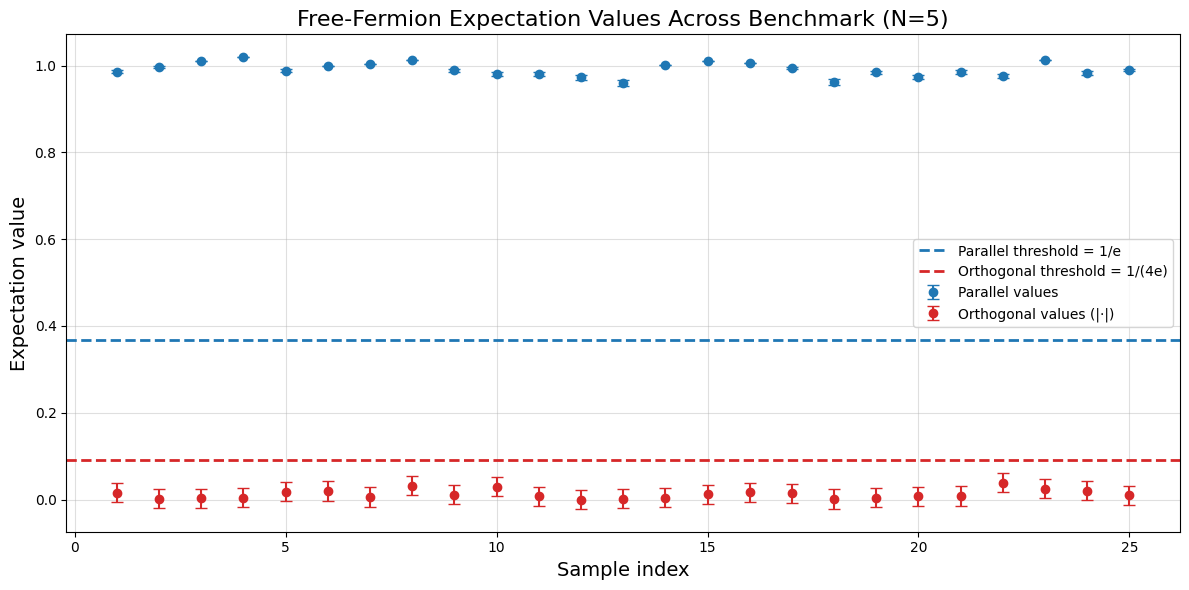

In [9]:
benchmark.plot_all_expectation_values()

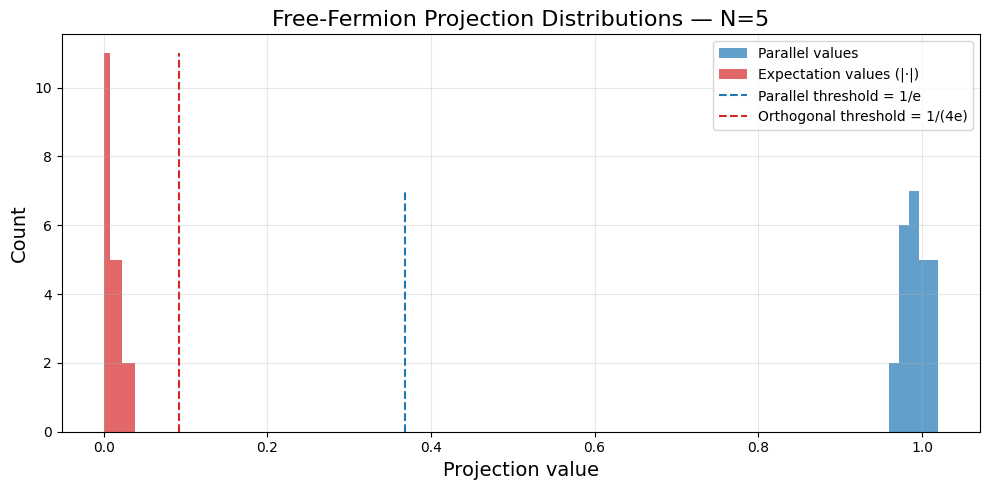

In [10]:
benchmark.plot_expectation_histograms(bins=5)